# Procesamiento Adaptativo de Señales - TP4 - Grupo 2

Importar librerias necesarias

In [16]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq, fftshift
from scipy.io import wavfile

Importar archivo de audio

In [17]:
Fs = 16e3
Fc = 2e3
v_sound = 343 # [m/s]

# Distancia entre sensores
d = [0.04, 0.08, 0.16]

subarray_sensors = [[3, 4, 5, 6, 7, 8,  9, 10, 11],
                    [1, 2, 3, 5, 7, 9, 11, 12, 13],
                    [0, 1, 3, 7, 11, 13, 14]]

M = [len(s) for s in subarray_sensors]

rate, data = wavfile.read('mtms-arrC1A.wav')
length = data.shape[0] / rate
N = len(data)
data = np.swapaxes(data,0,1) # Fila son canales, columnas son tiempo

## Punto 1

## Para empezar analizamos la señal del primer sensor y su espectro (elegido arbitrariamente)

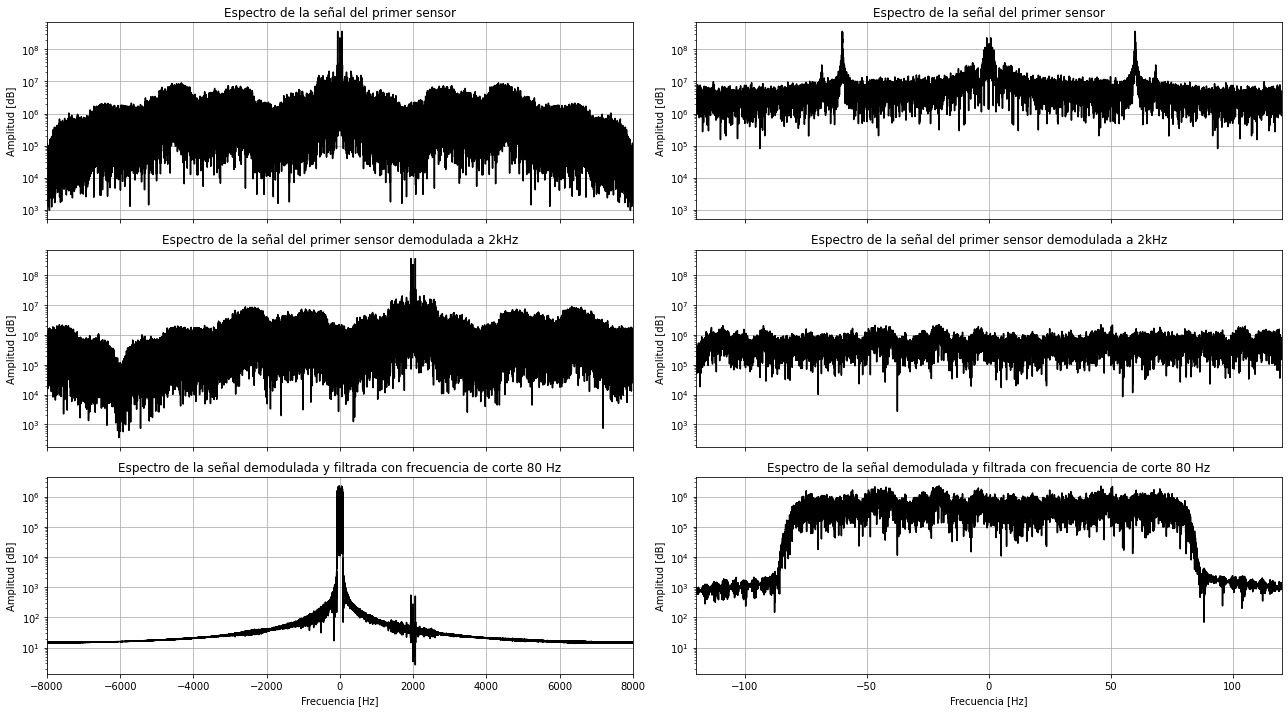

In [20]:
B = 80

fft1 = fftshift( fft(data[0]) )
fft_freq = fftshift( fftfreq(N, 1/Fs) )

fig, ax = plt.subplots(3, 2, figsize=(18, 10), sharex='col')

ax[0][0].semilogy(fft_freq, np.abs(fft1), 'k')
ax[0][0].grid()
ax[0][0].set_title('Espectro de la señal del primer sensor')
ax[0][0].set_ylabel('Amplitud [dB]')

ax[0][1].semilogy(fft_freq, np.abs(fft1), 'k')
ax[0][1].grid()
ax[0][1].set_title('Espectro de la señal del primer sensor')
ax[0][1].set_ylabel('Amplitud [dB]')

exp_demod = np.exp(2j*np.pi*Fc/Fs* np.arange(N))
data0_demod = exp_demod * data[0]
fft2 = fftshift( fft(data0_demod) )

ax[1][0].semilogy(fft_freq, np.abs(fft2), 'k')
ax[1][0].grid()
ax[1][0].set_title('Espectro de la señal del primer sensor demodulada a 2kHz')
ax[1][0].set_ylabel('Amplitud [dB]')

ax[1][1].semilogy(fft_freq, np.abs(fft2), 'k')
ax[1][1].grid()
ax[1][1].set_title('Espectro de la señal del primer sensor demodulada a 2kHz')
ax[1][1].set_ylabel('Amplitud [dB]')

a = 1
b = signal.firwin(4000+1, B, window='hamming', fs=Fs)
data0_filt = signal.lfilter(b, a, data0_demod)
fft3 = fftshift( fft(data0_filt) )

ax[2][0].semilogy(fft_freq, np.abs(fft3), 'k')
ax[2][0].grid()
ax[2][0].set_title(f'Espectro de la señal demodulada y filtrada con frecuencia de corte {B} Hz')
ax[2][0].set_xlabel('Frecuencia [Hz]')
ax[2][0].set_ylabel('Amplitud [dB]')
ax[2][0].set_xlim(-Fs/2, Fs/2)

ax[2][1].semilogy(fft_freq, np.abs(fft3), 'k')
ax[2][1].grid()
ax[2][1].set_title(f'Espectro de la señal demodulada y filtrada con frecuencia de corte {B} Hz')
ax[2][1].set_xlabel('Frecuencia [Hz]')
ax[2][1].set_ylabel('Amplitud [dB]')
ax[2][1].set_xlim(-B*1.5, B*1.5)

plt.tight_layout()
plt.show()

## Luego definimos una función que realice la demodulación y filtrado

In [6]:
def demod_lowpass(samples, Fc, Fs, order, B):
    exp_demod = np.exp(2j*np.pi*Fc/Fs* np.arange( len(samples) ))
    samples_demod = exp_demod * samples

    a = 1
    b = signal.firwin(order+1, B, window='hamming', fs=Fs)
    samples_filt = signal.lfilter(b, a, samples_demod)
    
    return samples_filt

## Filtramos la señal de cada uno de los sensores

In [21]:
B = 80

data_filt = np.zeros(np.shape(data), dtype=np.complex_)
for i, val in enumerate(data):
    data_filt[i] = demod_lowpass(data[i], Fc, Fs, 4000, B)

array_idx = 1

C:\Users\Matias\AppData\Local\Temp/ipykernel_1956/4109769526.py:2: RuntimeWarning: divide by zero encountered in log10
  img_data = 10*np.log10( np.abs(data_filt[ subarray_sensors[array_idx] ] ))


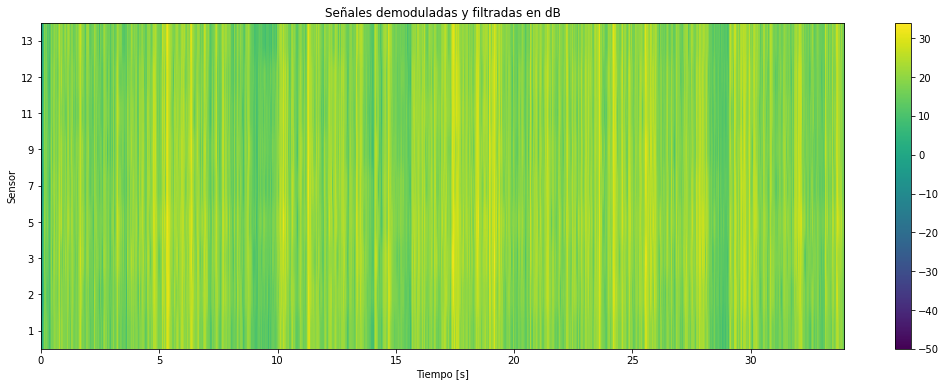

In [22]:
plt.figure(figsize=(18, 6))
img_data = 10*np.log10( np.abs(data_filt[ subarray_sensors[array_idx] ] ))
extent = [0, len(data[0])/Fs, 0 + 0.5, M[array_idx] + 0.5]
img = plt.imshow( img_data, interpolation='antialiased', aspect='auto', extent=extent, vmin = -50, origin='lower')
plt.colorbar(img, ax=plt.gca())
plt.title('Señales demoduladas y filtradas en dB')
plt.ylabel('Sensor')
plt.xlabel('Tiempo [s]')
plt.yticks(range(1, M[array_idx]+1), labels = subarray_sensors[array_idx])
plt.show()

C:\Users\Matias\AppData\Local\Temp/ipykernel_1956/2802072638.py:8: RuntimeWarning: divide by zero encountered in log10
  img_data = 10*np.log10( np.abs(data_fft))


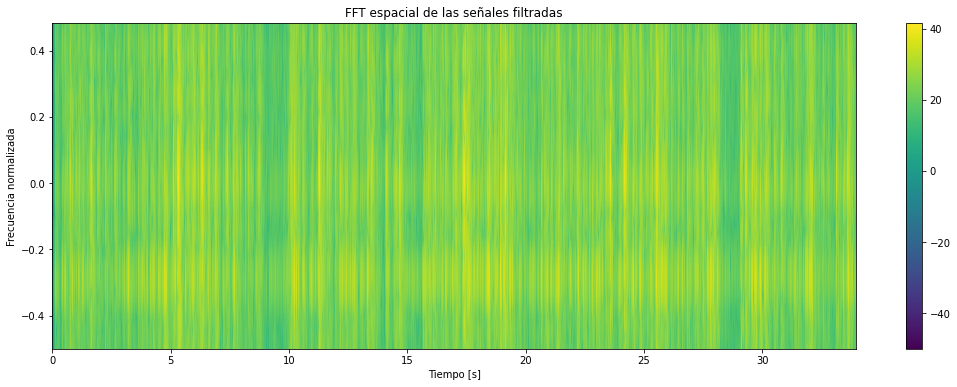

In [23]:
padding = 64 - M[array_idx]
data_fft = np.zeros((M[array_idx] + padding, N), dtype=np.complex_)
for t in range(len(data_filt[0])):
    data_pad = np.pad( data_filt[ subarray_sensors[array_idx] , t], (0, padding) )
    data_fft[:, t] = fftshift( fft( data_pad ) )

plt.figure(figsize=(18, 6))
img_data = 10*np.log10( np.abs(data_fft))
fft_freq = fftshift( fftfreq( len(data_fft) ) )
extent = [0, len(data[0])/Fs, fft_freq[0], fft_freq[-1]]
img = plt.imshow( img_data, interpolation='antialiased', aspect='auto', extent=extent, vmin = -50, origin='lower')
plt.colorbar(img, ax=plt.gca())
plt.title('FFT espacial de las señales filtradas')
plt.ylabel('Frecuencia normalizada')
plt.xlabel('Tiempo [s]')
plt.show()

C:\Users\Matias\AppData\Local\Temp/ipykernel_1956/468696792.py:6: RuntimeWarning: divide by zero encountered in log10
  img_data = 10*np.log10( np.abs(data_fft))
C:\Users\Matias\AppData\Local\Temp/ipykernel_1956/468696792.py:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  img = plt.pcolormesh(X, Y, img_data, shading='auto', antialiased=True, vmin = -50)


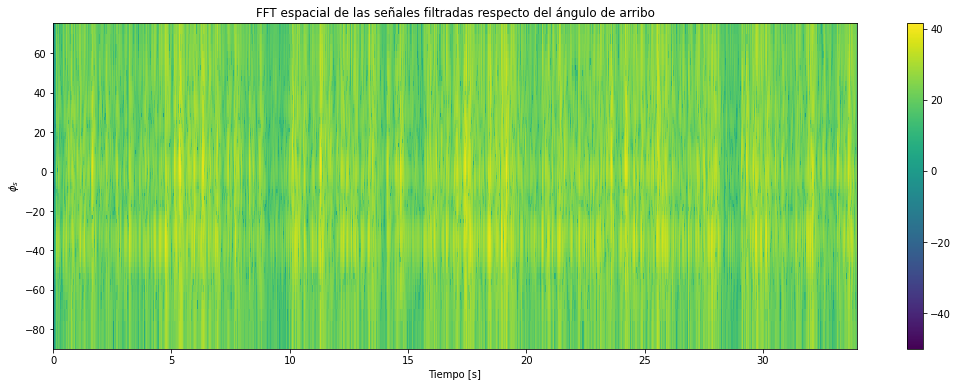

In [24]:
x = np.linspace(0, len(data_fft[0])/Fs, len(data_fft[0])+1)
y = np.arcsin(fft_freq*2) * 180/np.pi
X, Y = np.meshgrid(x, y)

plt.figure(figsize=(18, 6))
img_data = 10*np.log10( np.abs(data_fft))
img = plt.pcolormesh(X, Y, img_data, shading='auto', antialiased=True, vmin = -50)
plt.colorbar(img, ax=plt.gca())
plt.title('FFT espacial de las señales filtradas respecto del ángulo de arribo')
plt.ylabel('$\phi_s$')
plt.xlabel('Tiempo [s]')
plt.show()

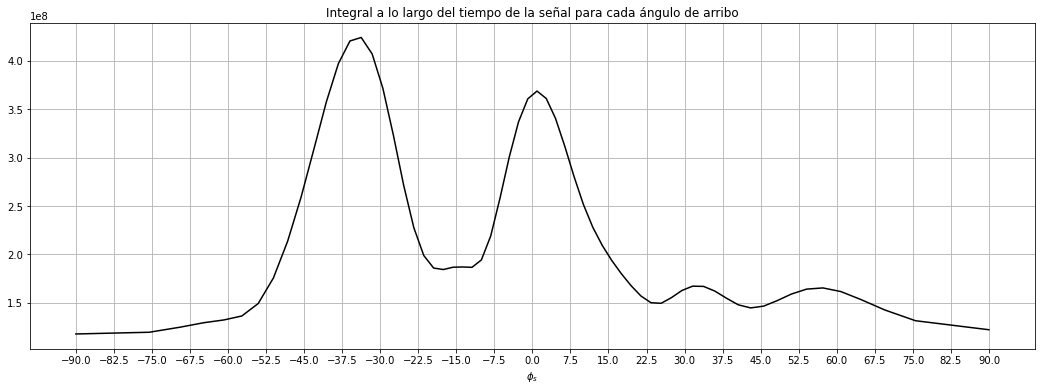

In [25]:
plt.figure(figsize=(18, 6))
plt.plot( np.arcsin(np.linspace(-1, 1, len(data_fft))) * 180/np.pi , np.abs(data_fft).sum(axis=1), 'k')
plt.title('Integral a lo largo del tiempo de la señal para cada ángulo de arribo')
plt.xticks(np.linspace(-90, 90, 24+1))
plt.xlabel('$\phi_s$')
plt.grid()
plt.show()

### Conclusiones

El sub arreglo de sensores óptimo para este caso es el segundo, que cuenta con los elementos 1, 2, 3, 5, 7, 9, 11, 12 y 13 y están espaciados a 8cm entre sí. Esto se debe a que se cumple que es el arreglo con mayor espaciado tal que cumpla que $d \leq \frac{λ}{2}$ y como $λ= \frac{c}{F_{c}}= \frac{343}{2000 Hz} \cong 0.1715 m$ y luego resulta $d \cong 8cm$.

El ancho de banda elegido para la señal demodulada es de 80 Hz dado que representa un 4% de la señal portadora. Se observa que $B<< F_{c}$ para que se cumpla la condición de narrowband.

Se observan señales provenientes de un angulo $\phi \simeq 0^ \circ $ y otra de $\phi \simeq 35^\circ$. De acuerdo a la documentación de la base de datos utilizada la primera se corresponde con el interlocutor que se encuentra a 1 metro de los micrófonos, mientras que la segunda se cree que es el sonido proveniente de la radio a pesar de que según se indica en la documentación esta se encuentra aproximadamente a $45^ \circ$ respecto del eje de simetría del arreglo de sensores. Esta discrepancia se podría deber a algún efecto acústico de la habitación como la reberverancia de la misma.
 

## Punto 2

Importo el archivo de audio (lo hago de nuevo para tenerlo cerquita, despues lo borramos esto)

In [26]:
Fs = 16e3
Fc = 2e3
v_sound = 343 # [m/s]

# Distancia entre sensores
d = [0.04, 0.08, 0.16]

subarray_sensors = [[3, 4, 5, 6, 7, 8,  9, 10, 11],
                    [1, 2, 3, 5, 7, 9, 11, 12, 13],
                    [0, 1, 3, 7, 11, 13, 14]]

M = [len(s) for s in subarray_sensors]

rate, data = wavfile.read('mtms-arrC1A.wav')
length = data.shape[0] / rate
N = len(data)
#data = np.swapaxes(data,0,1) # Fila son canales, columnas son tiempo

Para realizar la estimacion del beamformer optimo utilizando SMI primero separamos del audio original una muestra sin la voz del locutor, es decir que este compuesta solo de interferencia y ruido:

In [27]:
print(data)
#int_noise = data[:, rate*8:rate*9]
#print(int_noise)

[[    0     0     0 ...     0     0     0]
 [   23   360   533 ...   -67   559 -1580]
 [ -140   705   257 ...  -123   -63  -405]
 ...
 [-4958 -4797 -4645 ... -6198 -7853 -9678]
 [-4728 -4541 -4242 ... -6220 -7090 -9764]
 [-4563 -4264 -3350 ... -6105 -6557 -9809]]
